# Derive models of spacecraft with star tracker

Do all imports.

In [21]:
import sympy as sym
import numpy as np
from scipy import linalg
from scipy import signal
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

Create a visualizer to help with placement of reaction wheels.

In [22]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$. You cannot change the number of wheels, but it is likely that you **must** change the location of wheels in order for the system to be controllable.

In [30]:
wheels = [
    {'alpha': np.pi/2, 'delta': 0.},
    {'alpha': 2 * np.pi / 2, 'delta': 0.},
    {'alpha': 3 * np.pi / 2, 'delta': 0.},
    {'alpha': 7 * np.pi / 4, 'delta': -np.pi/2},
]

Show wheels in the visualizer. You will be warned if any wheel obscures the star tracker (i.e., the "scope") or if any two wheels are too close together.

In [31]:
design.show_wheels(vis, wheels)

Create a model of the spacecraft in URDF format. This will **overwrite** the file `spacecraft.urdf` in the `urdf` directory. Also, compute the mass $m$ and inertia matrix $J$ of the spacecraft (including all the wheels). These parameters will be used later when deriving equations of motion.

In [32]:
m, J = design.create_spacecraft(wheels)

display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}26.08 & 0.0 & 0.0\\0.0 & 23.72 & 0.0\\0.0 & 0.0 & 26.08\end{matrix}\right]$$

## Create stars

Specify the location of at most ten stars in terms of their right ascension $\alpha$ and declination $\delta$. It is likely that you **must** change the number and/or location of stars in order for the system to be observable.

In [83]:
stars = [
    {'alpha':  0.10, 'delta':  0},
    {'alpha':  0, 'delta':  0.10},
    {'alpha':  -0.1, 'delta':  0},
    {'alpha':  0, 'delta':  -0.1},
    {'alpha':  0, 'delta':  0}, # <-- To add a star, append a copy of this dict to the list. To change
                                      #     the location of a star, change the value of alpha and delta
]

Show where the stars will appear in the scope. The plot on the left shows $\alpha$ and $\delta$ gridelines. The plot on the right shows $y_\text{star}$ and $z_\text{star}$ gridlines.

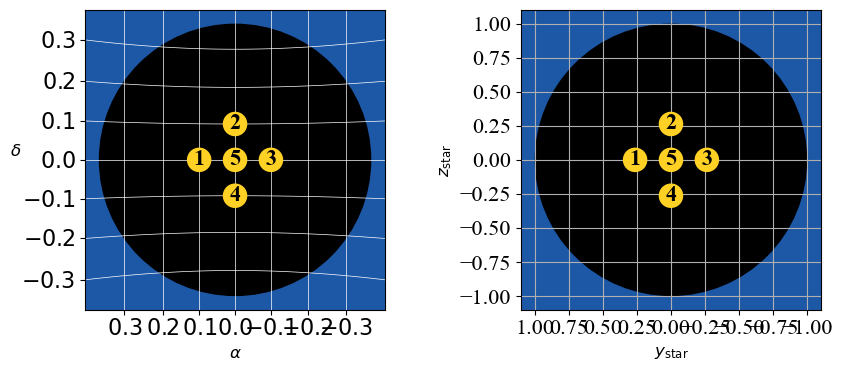

In [84]:
design.show_stars(stars)

Create a file with the location of stars. This will **overwrite** the file `stars.json` in the `urdf` directory.

In [85]:
design.create_stars(stars)

## Create dynamic model

Derive the equations of motion.

In [86]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [87]:
f

Matrix([
[                                                                                                                                                                                    (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                                 w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                                     w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-612323399573677*tau_1/260825000000000000000000000000000 + 400*tau_2/10433 + 183697019872103*tau_3/26082500000000000000000000000000 - 432978028117747*tau_4/260825000000000000000000000000000 - 236083333*w_y*w_z/2608250000],
[                                                   -100000000*tau_1/2372166667 - 2449293598294

## Create sensor model

Create symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star.

In [88]:
alpha, delta = sym.symbols('alpha, delta')

Derive the sensor model for one star.

In [89]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [90]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

Again, this sensor model is for **one star only**. You will have to use a copy of this same model for each star you defined in the "Create Stars" section of this notebook.

In [91]:
f_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f)

psi_e = 0
theta_e = 0
phi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_1_e = tau_2_e = tau_3_e = tau_4_e = 0

f_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([psi, theta, phi, w_x, w_y, w_z]))
A = A_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

print(A.tolist())
print(B.tolist())

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-2.347640753661179e-18, 0.03833988306335666, 7.042922260983532e-18, -1.660032696703717e-18], [-0.0421555539883151, -5.16256642580734e-18, 0.0421555539883151, 1.82524286400719e-18], [0.0, 0.0, 0.0, 0.03833988306335666]]


In [93]:
a1 = -0.1
d1 = 0
a2 = 0
d2 = 0.1
a3 = 0.1
d3 = 0
a4 = 0
d4 = -0.1
a5 = 0
d5 = 0



g1 = g.copy().subs(alpha, a1).subs(delta, d1)
g2 = g.copy().subs(alpha, a2).subs(delta, d2)
g3 = g.copy().subs(alpha, a3).subs(delta, d3)
g4 = g.copy().subs(alpha, a4).subs(delta, d4)
g5 = g.copy().subs(alpha, a5).subs(delta, d5)

G = sym.Matrix(np.block([[g1],[g2],[g3],[g4],[g5]]))

#print(G.tolist())

g_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G)

print(g_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e).T[0].tolist())

C_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G.jacobian([psi, theta, phi, w_x, w_y, w_z]))
C = C_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e)

D_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G.jacobian([tau_1, tau_2, tau_3, tau_4]))
D_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e)

print(sym.Matrix(C).tolist())


[-0.2633785142243077, 0.0, 0.0, 0.26337851422430775, 0.2633785142243077, 0.0, 0.0, -0.26337851422430775, 0.0, 0.0]
[[-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, 0.263378514224308, 0.0, 0.0, 0.0], [-2.62500000000000, 0.0, 0.263378514224308, 0.0, 0.0, 0.0], [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, -0.263378514224308, 0.0, 0.0, 0.0], [-2.62500000000000, 0.0, -0.263378514224308, 0.0, 0.0, 0.0], [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0], [-2.62500000000000, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, 0.0, 0.0, 0.0, 0.0]]


In [94]:
n = A.shape[1]
W_c = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W_c = np.block([W_c, col])
print(W_c.shape)
print(np.linalg.matrix_rank(W_c))
sym.Matrix(W_c)

(6, 24)
6


Matrix([
[                  0.0,                   0.0,                  0.0,                   0.0,                   0.0,                   0.0,                  0.0,    0.0383398830633567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[                  0.0,                   0.0,                  0.0,                   0.0,   -0.0421555539883151, -5.16256642580734e-18,   0.0421555539883151,  1.82524286400719e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[                  0.0,                   0.0,                  0.0,                   0.0, -2.34764075366118e-18,    0.0383398830633567, 7.04292226098353e-18, -1.66003269670372e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[-2.34764075366118e-18,    0.0383398830633567, 7.04292226098353e-18, -1.66003269670372e-18,                   0.0,                   0.0,                  0.0,                   0.0, 0.0, 0.0, 0.0, 0

In [95]:
n2 = A.shape[1]
W_o = C
for i in range(1, n2):
    row = C @ np.linalg.matrix_power(A, i)
    W_o = np.block([[W_o], [row]])
print(W_o.shape)
print(np.linalg.matrix_rank(W_o))
sym.Matrix(W_o)

(60, 6)
6


Matrix([
[-2.65142599685905,              0.0,                0.0,                0.0,              0.0,               0.0],
[              0.0,            2.625,  0.263378514224308,                0.0,              0.0,               0.0],
[           -2.625,              0.0,  0.263378514224308,                0.0,              0.0,               0.0],
[              0.0, 2.65142599685905,                0.0,                0.0,              0.0,               0.0],
[-2.65142599685905,              0.0,                0.0,                0.0,              0.0,               0.0],
[              0.0,            2.625, -0.263378514224308,                0.0,              0.0,               0.0],
[           -2.625,              0.0, -0.263378514224308,                0.0,              0.0,               0.0],
[              0.0, 2.65142599685905,                0.0,                0.0,              0.0,               0.0],
[           -2.625,              0.0,                0.0,      

In [96]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

Q = np.diag([5, 20, 60, 10, 10, 10])
R = np.eye(4)

K, P = lqr(A, B, Q, R)
print(sym.Matrix(K).tolist())

eigsc = linalg.eigvals(A - B @ K)
#print(eigsc)
sym.Matrix(K)
realc = eigsc.real.tolist()
imagc = eigsc.imag.tolist()

#K2 = signal.place_poles(A, B, pc).gain_matrix

[[-3.78701535857112e-16, -3.16227766016838, 4.96812722514226e-15, 1.41876312532732e-15, -8.94508225632956, -1.98994821346822e-15], [-1.02982371392575e-16, -4.53064843404049e-16, 7.74596669241483, 20.3486695513446, -3.51901814918395e-15, -1.95906707059117e-15], [3.78701535857112e-16, 3.16227766016838, -4.01951989352548e-15, 1.07323017796882e-15, 8.94508225632956, 1.98994821346822e-15], [2.23606797749979, 6.33060947260181e-16, -8.52658575547852e-16, -2.84011975230725e-15, 2.19713230167733e-15, 11.2536432343609]]


In [99]:
po = np.array([-0.1, -0.3, -1, -0.5, -0.7,  -0.9])

#L = signal.place_poles(A.T, C.T, po).gain_matrix.T

Qo = np.diag([10, 5, 10, 10, 10, 5, 5, 10, 5, 5])
Ro = np.diag([10, 5, 10, 10, 10, 5])
L_T, P = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo))
L = L_T.T


eigso = linalg.eigvals(A - L @ C)
#print(eigso)
print(sym.Matrix(L).tolist())
realo = eigso.real.tolist()
imago = eigso.imag.tolist()

[[-0.625109168105708, 0.00939777301889200, -0.600083339596343, 4.13386338148511e-17, -0.625109168105708, -0.00939777301889196, -0.318837215835956, 4.13386338148511e-17, -0.309439442817064, 2.04633117976011e-17], [-4.13386338148511e-17, 0.412087923966302, -6.89170921027554e-17, 0.832472864454040, -4.13386338148511e-17, 0.412087923966302, -6.46807754382456e-18, 0.832472864454040, -2.04633117976011e-17, 0.412087923966302], [-0.189214369047960, 0.775351286864255, 1.36337404962892, -2.81779461334441e-16, -0.189214369047960, -0.775351286864256, -0.869015548914051, -2.81779461334441e-16, -0.0936642620497959, -1.39485523427609e-16], [-0.0754853592604742, 0.320201998225909, 0.565670977957817, 4.71342761013303e-17, -0.0754853592604742, -0.320201998225909, -0.357568507472910, 4.71342761013303e-17, -0.0373665092470010, 2.33322511947463e-17], [-5.14403078830304e-17, 0.265729329191658, -2.15764619002347e-16, 0.536808877368897, -5.14403078830304e-17, 0.265729329191658, 5.69546923046477e-17, 0.5368088

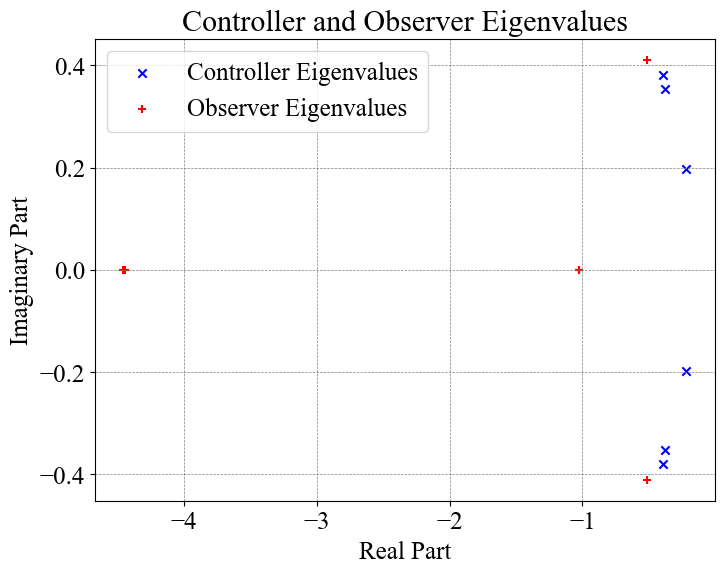

In [79]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


rcParams['font.family'] = 'Times New Roman' 
rcParams['font.size'] = 18

plt.figure(figsize=(8, 6))
plt.scatter(realc, imagc, color='blue', marker='x', label='Controller Eigenvalues')
plt.scatter(realo, imago, color='red', marker='+', label='Observer Eigenvalues')

# Add labels and grid
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal axis
# plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical axis
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.title("Controller and Observer Eigenvalues")
plt.xlabel("Real Part", )
plt.ylabel("Imaginary Part")
plt.legend()

plt.savefig("eigs.png", dpi=300, bbox_inches='tight')
plt.show()



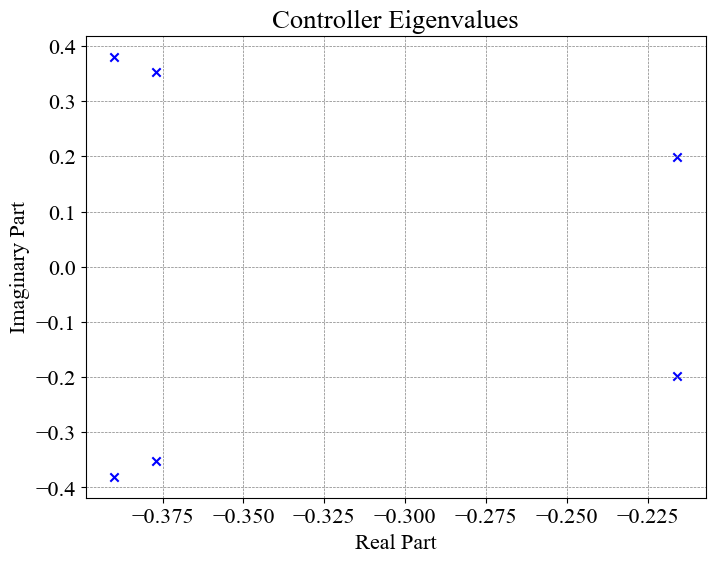

In [80]:
rcParams['font.family'] = 'Times New Roman' 
rcParams['font.size'] = 16

plt.figure(figsize=(8, 6))
plt.scatter(realc, imagc, color='blue', marker='x', label='Controller Eigenvalues')

# Add labels and grid
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Horizontal axis
# plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Vertical axis
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.title("Controller Eigenvalues")
plt.xlabel("Real Part", )
plt.ylabel("Imaginary Part")
#plt.legend(loc='center right')

plt.savefig("eigs_c.png", dpi=300, bbox_inches='tight')
plt.show()